In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
from vqls import *
from utils import *

label = 'relu'
nq = 4
n_step = 16
file_path = f"results_{label}_{nq}.json"

In [2]:
df = pd.read_json(file_path)
df.head()

,Condition number,norm(yk),training_cost,exe_time,in_train_weights,RSS_q,RSS_h,seed
0,12730.232709,1.046311,"[0.4771129396, 0.4542505499, 0.4495125291, 0.4...",120942.523607,"[[0.4843168531, 2.3249346899, 0.8272285173, 1....",5.329755,4.669781,12
1,12730.232709,1.046311,"[0.43838630640000004, 0.3788885008, 0.47070683...",95534.714161,"[[0.7807175907, 1.4136394771, 1.2910086078, 0....",2.054769,1.748778,33
2,12730.232709,1.046311,"[0.4626666701, 0.46884439850000004, 0.42662472...",145357.089480,"[[3.038013838, 1.7191808138, 3.0557780395, 2.2...",2.039573,1.732888,4
3,12730.232709,1.046311,"[0.4467984163, 0.4098396192, 0.453916125300000...",187569.926517,"[[2.0343416195, 1.5932577347999999, 1.65983339...",2.055160,1.752819,88
4,12730.232709,1.046311,"[0.3801968221, 0.4099021594, 0.4399620641, 0.4...",140572.945544,"[[2.7439593952, 3.042760231, 2.7306551821, 1.6...",5.318409,4.653024,8


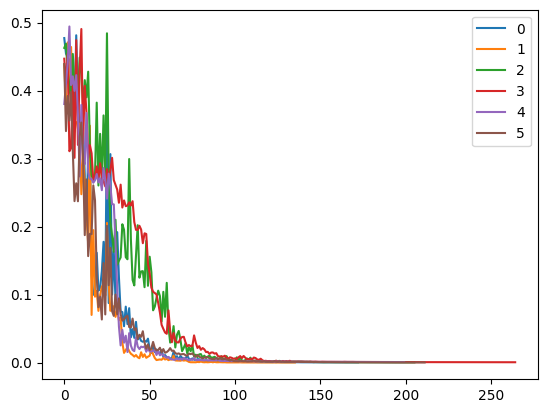

In [3]:
#Visualize training cost and obtain best performing epoch
argM = []
for i,item in enumerate(df["training_cost"].values):
    argM.append(np.argmin(item))
    plt.plot(item, label = i)
plt.legend()

In [4]:
## experimental specific settings


In [5]:

func_out = {'sigmoid': sigmoid_t,'tanh': tanh_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}
func = func_out[label]


#############################################################################################
###################################### System Preparatio and _sin_#################
#############################################################################################

lower = 0. 
upper = 1. 
f_i = 0.0 
scaled=False
x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
y = [func(value,f_i) for value in x]

if scaled:
    norm = np.linalg.norm(y)
    y = y / norm

tck=splrep(x,y,k=1) #coeffs
matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled)


#############################################################################################
################################# VQLS and Linear Prob. Solving #############################
#############################################################################################


k_numb=np.linalg.cond(np.array(matrix))

vqls_circuit = VQLS(matrix,v_norm,nq,opt='COBYLA') 


beta_classic                 : [ 0.00000000e+00  6.25024975e-02 -8.75034965e-01  5.68772727e+00
 -2.27509091e+01  6.25650000e+01 -1.25130000e+02  1.87695000e+02
 -2.14430000e+02  1.87820000e+02 -1.24930000e+02  6.28200000e+01
 -2.24300000e+01  6.07000000e+00 -4.30000000e-01  5.70000000e-01]


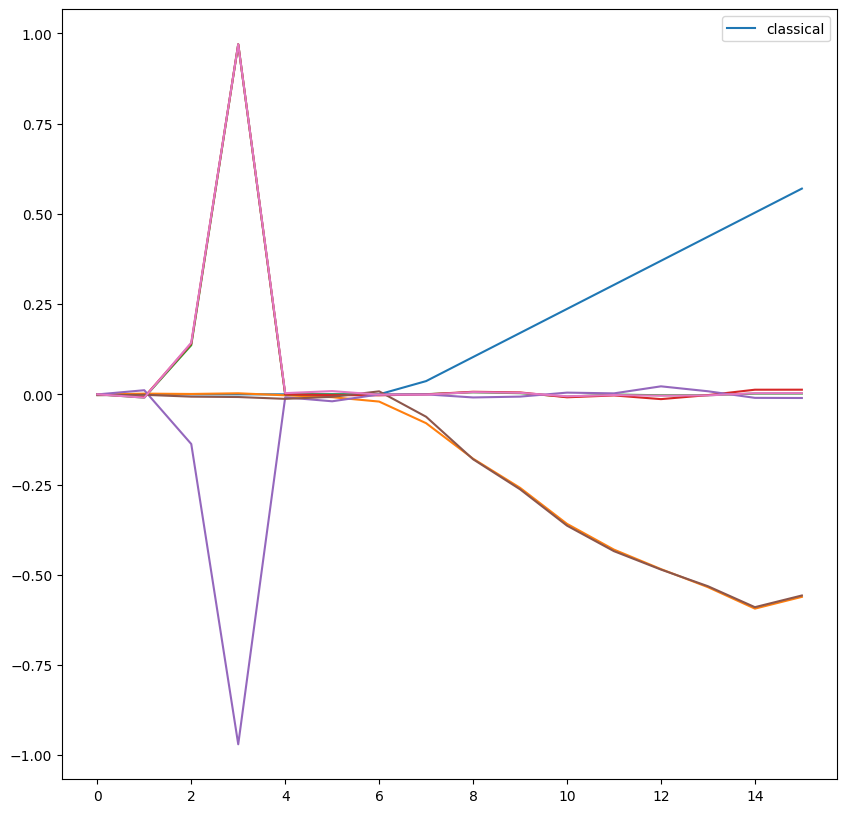

In [6]:
c = np.linalg.solve(matrix,vector)
print('beta_classic                 :',c)
plt.figure(figsize=(10,10))

y_c=np.dot(matrix,c) #classic
plt.plot(range(len(y_c)),y_c, label="classical")

for i,item in enumerate(df['in_train_weights']):
  weights = item[argM[i]]
  q = vqls_circuit.solution(weights).real
  y_q=np.dot(matrix,q) #hybrid
                        #Quantum

  y_fq=[]
  for el in matrix:
    y_fq.append(vqls_circuit.direct_prod2(weights,el))

  #plt.plot(range(len(y_fq)),y_q,label= f"h {i}")
  plt.plot(range(len(y_fq)),y_fq, )#label= f"fq {i}")
plt.legend()

In [7]:
best = np.argmin(df['RSS_q'])
weights = df['in_train_weights'][best][argM[best]]


In [8]:
print()


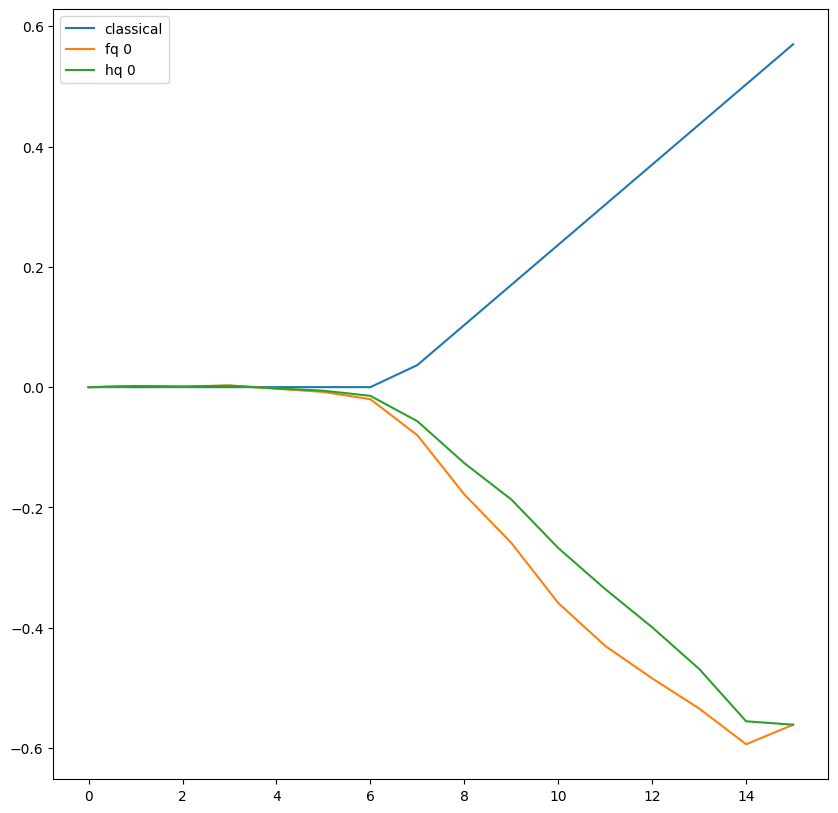

In [11]:
#Best performing model based on RSS
best = np.argmin(df['RSS_q'])
best = 0

weights = df['in_train_weights'][best][argM[best]]
q = vqls_circuit.solution(weights).real
y_q=np.dot(matrix,q) #hybrid
                  #Quantum
plt.figure(figsize=(10,10))
plt.plot(range(len(y_c)),y_c, label="classical")

y_fq=[]
for el in matrix:
  y_fq.append(vqls_circuit.direct_prod2(weights,el))

#plt.plot(range(len(y_fq)),y_q,label= f"h {i}")
#plt.plot(range(len(y_fq)),np.abs(y_fq), label= f"fq abs {best}")
#plt.plot(range(len(y_fq)),np.abs(y_q), label= f"hq abs {best}")
plt.plot(range(len(y_fq)),(y_fq), label= f"fq {best}")
plt.plot(range(len(y_fq)),(y_q), label= f"hq {best}")
plt.legend()
#plt.savefig(f'{file_path[:-5]}.png')
plt.show()

In [10]:
best_models = pd.DataFrame(columns=[])